# Minimierung der Lateness jedes Produktionsauftrags

$$
L_j = C_j - d_j
$$


- $L_j$: Lateness (Verspätung oder Frühfertigung) des Jobs $j$
- $C_j$: tatsächliche Fertigstellungszeit (Completion Time) von Job $j$
- $d_j$: Deadline bzw. geplanter Fertigstellungstermin von Job $j$

**Interpretation:**

- $L_j > 0$: Job ist **verspätet**
- $L_j = 0$: Job ist **pünktlich**
- $L_j < 0$: Job ist **zu früh** fertig

In [2]:
import pandas as pd

# Utils
import src.utils.visualization.gantt_diagram as gantt
from src.utils.rolling_process.rolling_filter import *
from src.utils.editor import enrich_schedule_dframe

from src.utils.logging import print_experiment_log

# Analysis utils
from src.utils.analysis_basics import check_constraints as check
from src.utils.analysis_basics.check_lateness import get_jobs_with_lateness_metrics, get_jobs_aggregated
from src.utils.analysis.compare_sequences import get_comparison_dataframe, compute_sum_levenshtein_distance, \
    compute_mean_kendall_tau, get_shared_operations_number

# Solver
from src.solvers.converter import get_job_ops_dict, get_times_dict, get_schedule_dframe, get_active_ops
from src.solvers.cp.lateness import solve_jssp_lateness_with_start_deviation_minimization, \
    solve_jssp_lateness_with_order_deviation_minimization

# Simulation
from src.simulation.ProductionRollingSimulation import ProductionSimulation

# Data access
from configs.path_manager import get_path

pd.set_option('display.min_rows', 12)
pd.set_option('display.max_rows', 16)

In [3]:
# Hard termination condition for schedulers
max_time = 60*3     # 3 min

# File paths
examples_data_path = get_path("data", "examples")
basic_data_path = get_path("data", "basic")

# Simulation
simulation = ProductionSimulation(sigma = 0.2)

In [4]:
df_jssp = pd.read_csv(basic_data_path / "jssp_final.csv")
df_jssp

,Job,Routing_ID,Operation,Machine,Processing Time
0,J25-0000,8,0,M00,76
1,J25-0000,8,1,M01,69
2,J25-0000,8,2,M03,76
3,J25-0000,8,3,M05,51
4,J25-0000,8,4,M02,85
5,J25-0000,8,5,M09,11
...,...,...,...,...,...
72494,J25-7249,4,4,M03,26
72495,J25-7249,4,5,M04,69
72496,J25-7249,4,6,M08,21


In [5]:
df_jobs_times = pd.read_csv(basic_data_path / "jobs_times_final.csv")
df_jobs_times

,Job,Routing_ID,Arrival,Ready Time,Job Processing Time,Deadline
0,J25-0000,8,79,1440,597,3660
1,J25-0001,6,129,1440,416,2338
2,J25-0002,0,198,1440,395,3744
3,J25-0003,2,243,1440,568,3379
4,J25-0004,3,287,1440,655,4856
5,J25-0005,1,498,1440,510,3106
...,...,...,...,...,...,...
7244,J25-7244,3,518085,518400,655,520389
7245,J25-7245,9,518089,518400,540,519640
7246,J25-7246,6,518116,518400,416,520157


## Day 1
- On day 0, the first jobs (production orders) arrive, so nothing can be planned yet
- On day 1, the initial planning takes place

In [6]:
day_length = 1440

day_numb = 1
day_start = day_length*day_numb
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 01: [1440, 2880)


In [7]:
# New and unfinished jobs
df_jobs_times_current = get_current_jobs(
    df_jobs_times, df_previous_not_started = None, ready_time=day_start
)
df_jobs_times_current

,Job,Routing_ID,Arrival,Ready Time,Job Processing Time,Deadline
0,J25-0000,8,79,1440,597,3660
1,J25-0001,6,129,1440,416,2338
2,J25-0002,0,198,1440,395,3744
3,J25-0003,2,243,1440,568,3379
4,J25-0004,3,287,1440,655,4856
5,J25-0005,1,498,1440,510,3106
6,J25-0006,9,790,1440,540,3539
7,J25-0007,5,925,1440,496,2929
8,J25-0008,4,988,1440,393,3541
9,J25-0009,7,1004,1440,539,3578


In [8]:
# current JSSP (Job Shop Scheduling Problem) basic data
df_jssp_current = filter_current_jssp(df_jssp, df_jobs_times_current, exclusion_dataframes_list = None)
df_jssp_current

,Job,Routing_ID,Operation,Machine,Processing Time
0,J25-0000,8,0,M00,76
1,J25-0000,8,1,M01,69
2,J25-0000,8,2,M03,76
3,J25-0000,8,3,M05,51
4,J25-0000,8,4,M02,85
5,J25-0000,8,5,M09,11
...,...,...,...,...,...
154,J25-0015,5,4,M08,48
155,J25-0015,5,5,M09,72
156,J25-0015,5,6,M00,47


### Scheduling Preperation

In [9]:
job_ops_dict = get_job_ops_dict(df_jssp_current)
job_ops_dict

{'J25-0000': [(0, 'M00', 76),
  (1, 'M01', 69),
  (2, 'M03', 76),
  (3, 'M05', 51),
  (4, 'M02', 85),
  (5, 'M09', 11),
  (6, 'M06', 40),
  (7, 'M07', 89),
  (8, 'M04', 26),
  (9, 'M08', 74)],
 'J25-0001': [(0, 'M01', 46),
  (1, 'M00', 37),
  (2, 'M03', 61),
  (3, 'M02', 13),
  (4, 'M06', 32),
  (5, 'M05', 21),
  (6, 'M09', 32),
  (7, 'M08', 89),
  (8, 'M07', 30),
  (9, 'M04', 55)],
 'J25-0002': [(0, 'M00', 29),
  (1, 'M01', 78),
  (2, 'M02', 9),
  (3, 'M03', 36),
  (4, 'M04', 49),
  (5, 'M05', 11),
  (6, 'M06', 62),
  (7, 'M07', 56),
  (8, 'M08', 44),
  (9, 'M09', 21)],
 'J25-0003': [(0, 'M01', 91),
  (1, 'M00', 85),
  (2, 'M03', 39),
  (3, 'M02', 74),
  (4, 'M08', 90),
  (5, 'M05', 10),
  (6, 'M07', 12),
  (7, 'M06', 89),
  (8, 'M09', 45),
  (9, 'M04', 33)],
 'J25-0004': [(0, 'M01', 81),
  (1, 'M02', 95),
  (2, 'M00', 71),
  (3, 'M04', 99),
  (4, 'M06', 9),
  (5, 'M08', 52),
  (6, 'M07', 85),
  (7, 'M03', 98),
  (8, 'M09', 22),
  (9, 'M05', 43)],
 'J25-0005': [(0, 'M00', 43),
  (1, '

In [10]:
times_dict = get_times_dict(df_jobs_times_current)
times_dict

{'J25-0000': (1440, 3660),
 'J25-0001': (1440, 2338),
 'J25-0002': (1440, 3744),
 'J25-0003': (1440, 3379),
 'J25-0004': (1440, 4856),
 'J25-0005': (1440, 3106),
 'J25-0006': (1440, 3539),
 'J25-0007': (1440, 2929),
 'J25-0008': (1440, 3541),
 'J25-0009': (1440, 3578),
 'J25-0010': (1440, 3345),
 'J25-0011': (1440, 3210),
 'J25-0012': (1440, 4385),
 'J25-0013': (1440, 2567),
 'J25-0014': (1440, 3315),
 'J25-0015': (1440, 2981)}

### Schedule

In [11]:
schedule, _ = solve_jssp_lateness_with_start_deviation_minimization(
        job_ops=job_ops_dict,
        times_dict=times_dict,
        previous_schedule=None,
        active_ops=None,
        w_t= 10, w_e=2, w_first=1,
        main_pct=1, duration_buffer_factor = 2,
        schedule_start=day_start, msg=False,
        solver_time_limit=max_time, solver_relative_gap_limit=0.05
    )

In [12]:
df_schedule = get_schedule_dframe(schedule)
df_schedule.to_csv(examples_data_path / "lateness_schedule_day_01.csv", index=False)
df_schedule

,Job,Operation,Machine,Start,Processing Time,End
0,J25-0000,0,M00,2481,76,2557
1,J25-0000,1,M01,2594,69,2663
2,J25-0000,2,M03,2681,76,2757
3,J25-0000,3,M05,2783,51,2834
4,J25-0000,4,M02,2834,85,2919
5,J25-0000,5,M09,2970,11,2981
...,...,...,...,...,...,...
154,J25-0015,4,M08,2277,48,2325
155,J25-0015,5,M09,2325,72,2397
156,J25-0015,6,M00,2434,47,2481


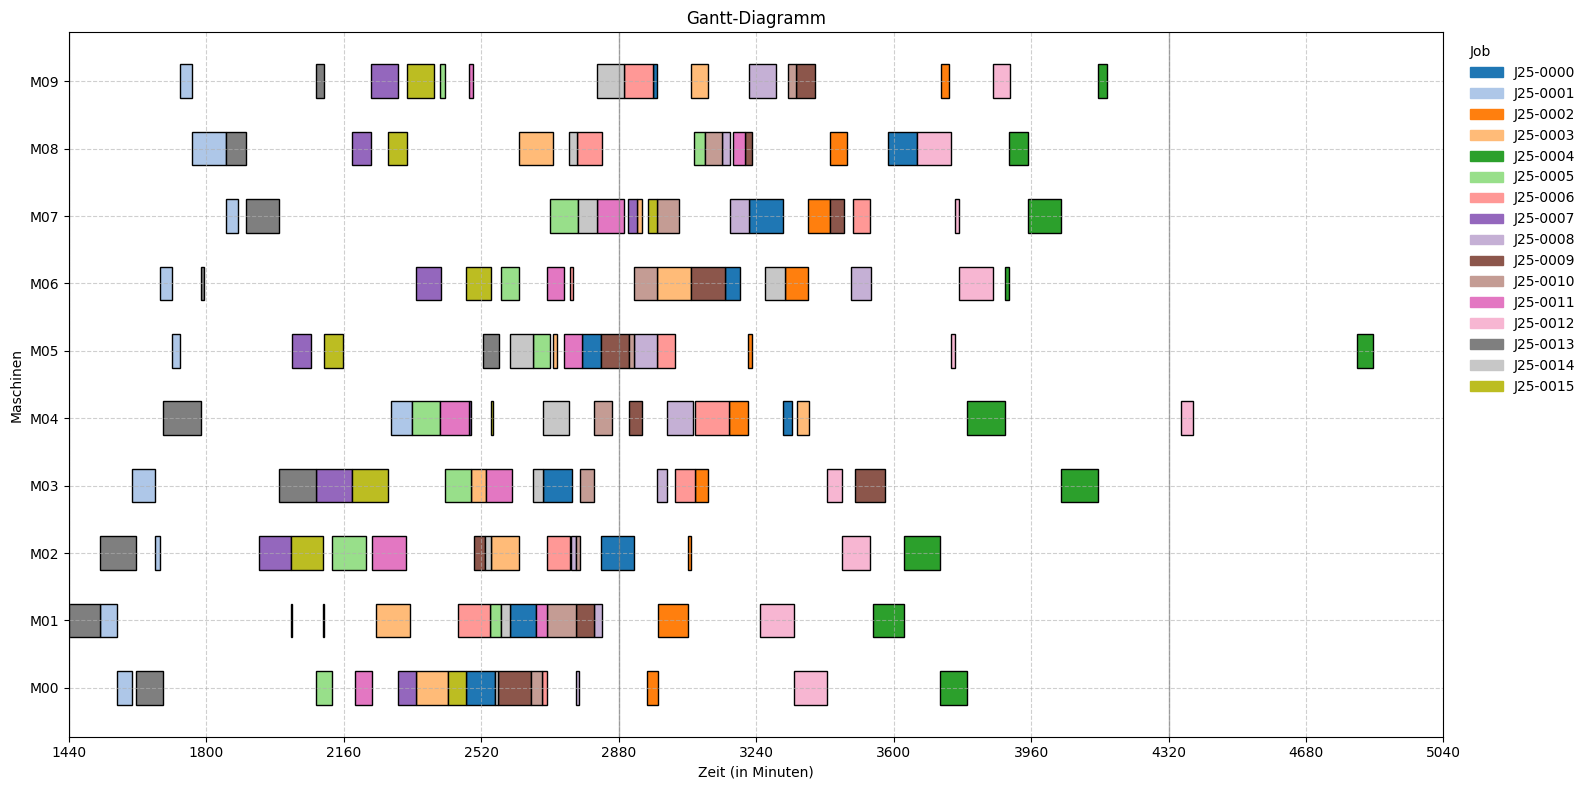

+ No machine conflicts found.
+ All job operations are scheduled in non-overlapping, correct sequence.
+ All operations start at or after the earliest allowed time.
+ All durations match the difference between start and end.


True

In [13]:
gantt.get_plot(df_schedule, perspective="Machine")
#df_schedule_with_info = enrich_schedule_dframe(df_schedule, df_jobs_times)
check.check_core_schedule_constraints(df_schedule)
check.is_start_correct(df_schedule, df_jobs_times_current)
check.is_duration_correct(df_schedule)


### Simulation

In [14]:
simulation.run(dframe_schedule_plan = df_schedule, start_time = day_start, end_time=day_end)

[Day 1 00:00:00] Job J25-0013 started on M01
[Day 1 01:08:00] Job J25-0013 finished on M01 (after 68 minutes)
[Day 1 01:21:00] Job J25-0001 started on M01
[Day 1 01:21:00] Job J25-0013 started on M02
[Day 1 02:04:00] Job J25-0001 finished on M01 (after 43 minutes)
[Day 1 02:07:00] Job J25-0001 started on M00
[Day 1 02:32:00] Job J25-0001 finished on M00 (after 25 minutes)
[Day 1 02:44:00] Job J25-0001 started on M03
[Day 1 03:22:00] Job J25-0013 finished on M02 (after 121 minutes)
[Day 1 03:22:00] Job J25-0013 started on M00
[Day 1 03:28:00] Job J25-0001 finished on M03 (after 44 minutes)
[Day 1 03:45:00] Job J25-0001 started on M02
[Day 1 03:57:00] Job J25-0001 finished on M02 (after 12 minutes)
[Day 1 03:58:00] Job J25-0001 started on M06
[Day 1 04:37:00] Job J25-0001 finished on M06 (after 39 minutes)
[Day 1 04:37:00] Job J25-0001 started on M05
[Day 1 04:58:00] Job J25-0001 finished on M05 (after 21 minutes)
[Day 1 04:58:00] Job J25-0001 started on M09
[Day 1 05:06:00] Job J25-0013

In [15]:
df_execution = simulation.get_finished_operations_df()
df_execution

,Job,Operation,Machine,Start,Processing Time,End
0,J25-0000,0,M00,2506.0,78.0,2584.0
1,J25-0000,1,M01,2609.0,86.0,2695.0
2,J25-0000,2,M03,2695.0,67.0,2762.0
3,J25-0000,3,M05,2799.0,61.0,2860.0
4,J25-0001,0,M01,1521.0,43.0,1564.0
5,J25-0001,1,M00,1567.0,25.0,1592.0
...,...,...,...,...,...,...
84,J25-0015,3,M03,2207.0,86.0,2293.0
85,J25-0015,4,M08,2293.0,54.0,2347.0
86,J25-0015,5,M09,2347.0,76.0,2423.0


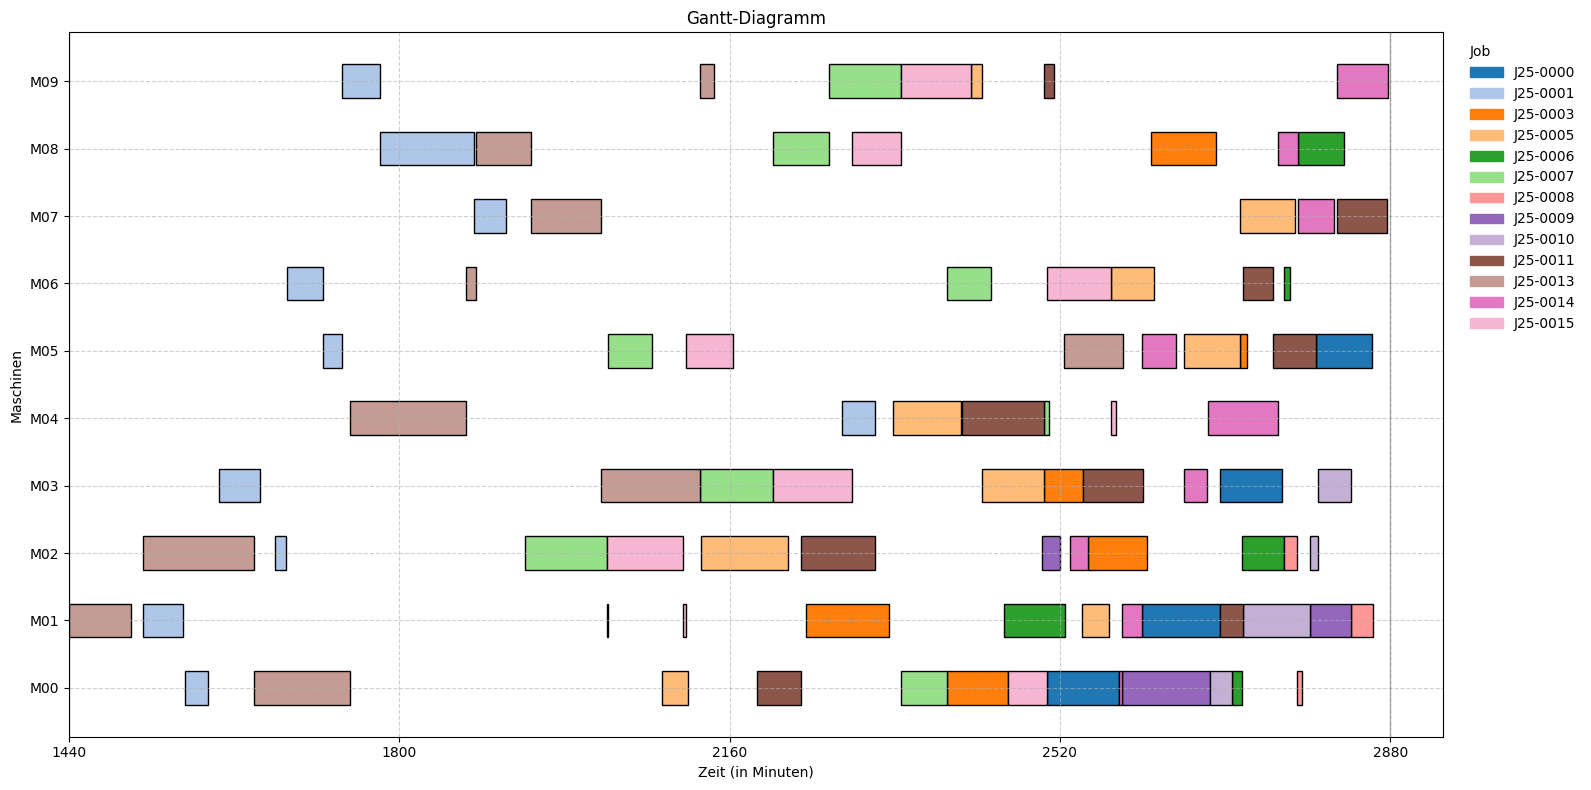

In [16]:
gantt.get_plot(df_execution, perspective="Machine")

In [17]:
df_active = simulation.get_active_operations_df()
df_active

,Job,Operation,Machine,Start,Processing Time,End,Expected End
0,J25-0000,4,M02,2860.0,135.0,2995.0,2945.0
1,J25-0009,3,M05,2860.0,61.0,2921.0,2934.0
2,J25-0010,4,M04,2837.0,68.0,2905.0,2886.0


In [18]:
df_not_started = simulation.get_not_started_operations_df(df_schedule)
df_not_started

,Job,Operation,Machine,Start,Processing Time,End
0,J25-0000,5,M09,2970,11,2981
1,J25-0000,6,M06,3158,40,3198
2,J25-0000,7,M07,3220,89,3309
3,J25-0000,8,M04,3309,26,3335
4,J25-0000,9,M08,3586,74,3660
5,J25-0002,0,M00,2954,29,2983
...,...,...,...,...,...,...
61,J25-0012,6,M07,3760,12,3772
62,J25-0012,7,M06,3772,89,3861
63,J25-0012,8,M09,3861,45,3906


## Day 2
- This is where the new scheduling takes place, i.e., scheduling with specific consideration of the simulation.

In [19]:
day_numb = 2
day_start = day_length*day_numb
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 02: [2880, 4320)


In [20]:
# New and unfinished jobs
df_jobs_times_current = get_current_jobs(df_jobs_times, df_not_started, ready_time=day_start)
df_jobs_times_current

,Job,Routing_ID,Arrival,Ready Time,Job Processing Time,Deadline
0,J25-0000,8,79,1440,597,3660
2,J25-0002,0,198,1440,395,3744
3,J25-0003,2,243,1440,568,3379
4,J25-0004,3,287,1440,655,4856
5,J25-0005,1,498,1440,510,3106
6,J25-0006,9,790,1440,540,3539
...,...,...,...,...,...,...
32,J25-0032,6,2654,2880,416,3881
33,J25-0033,2,2660,2880,568,6738
34,J25-0034,8,2715,2880,597,6387


In [21]:
df_jssp_current = filter_current_jssp(
    df_jssp = df_jssp,
    df_jobs_times_current = df_jobs_times_current,
    exclusion_dataframes_list = [df_active, df_execution]
)
df_jssp_current

,Job,Routing_ID,Operation,Machine,Processing Time
5,J25-0000,8,5,M09,11
6,J25-0000,8,6,M06,40
7,J25-0000,8,7,M07,89
8,J25-0000,8,8,M04,26
9,J25-0000,8,9,M08,74
20,J25-0002,0,0,M00,29
...,...,...,...,...,...
374,J25-0037,7,4,M04,32
375,J25-0037,7,5,M06,88
376,J25-0037,7,6,M08,19


### Scheduling Preparation

In [22]:
# jssp dict and job times information dict
job_ops_dict = get_job_ops_dict(df_jssp_current)
times_dict = get_times_dict(df_jobs_times_current)

In [23]:
active_ops = get_active_ops(df_active)
active_ops

[('J25-0000', 4, 'M02', 2860, 135, 2995),
 ('J25-0009', 3, 'M05', 2860, 61, 2921),
 ('J25-0010', 4, 'M04', 2837, 68, 2905)]

In [24]:
previous_schedule = schedule
df_previous_schedule = df_schedule

### Scheduling (Rescheduling)

#### a) Simple Scheduling


===== EXPERIMENT LOG SUMMARY =====
[EXPERIMENT_INFO]
  total_number_of_operations                        : 287
  number_of_operations_with_previous_schedule       : 0
  number_of_active_operation_to_consider            : 3
  schedule_start                                    : 2880
[EXPERIMENT_CONFIG]
  main_pct                                          : 1.0
  w_t                                               : 5
  w_e                                               : 1
  w_first                                           : 1
  deviation_type                                    : start
  solver_time_limit                                 : 180
  solver_relative_gap_limit                         : 0.05
[MODEL_INFO]
  number_of_variables                               : 795
  number_of_constraints                             : 1059
  number_of_deviation_terms                         : 0
[SOLVER_INFO]
  status                                            : OPTIMAL
  objective_value               

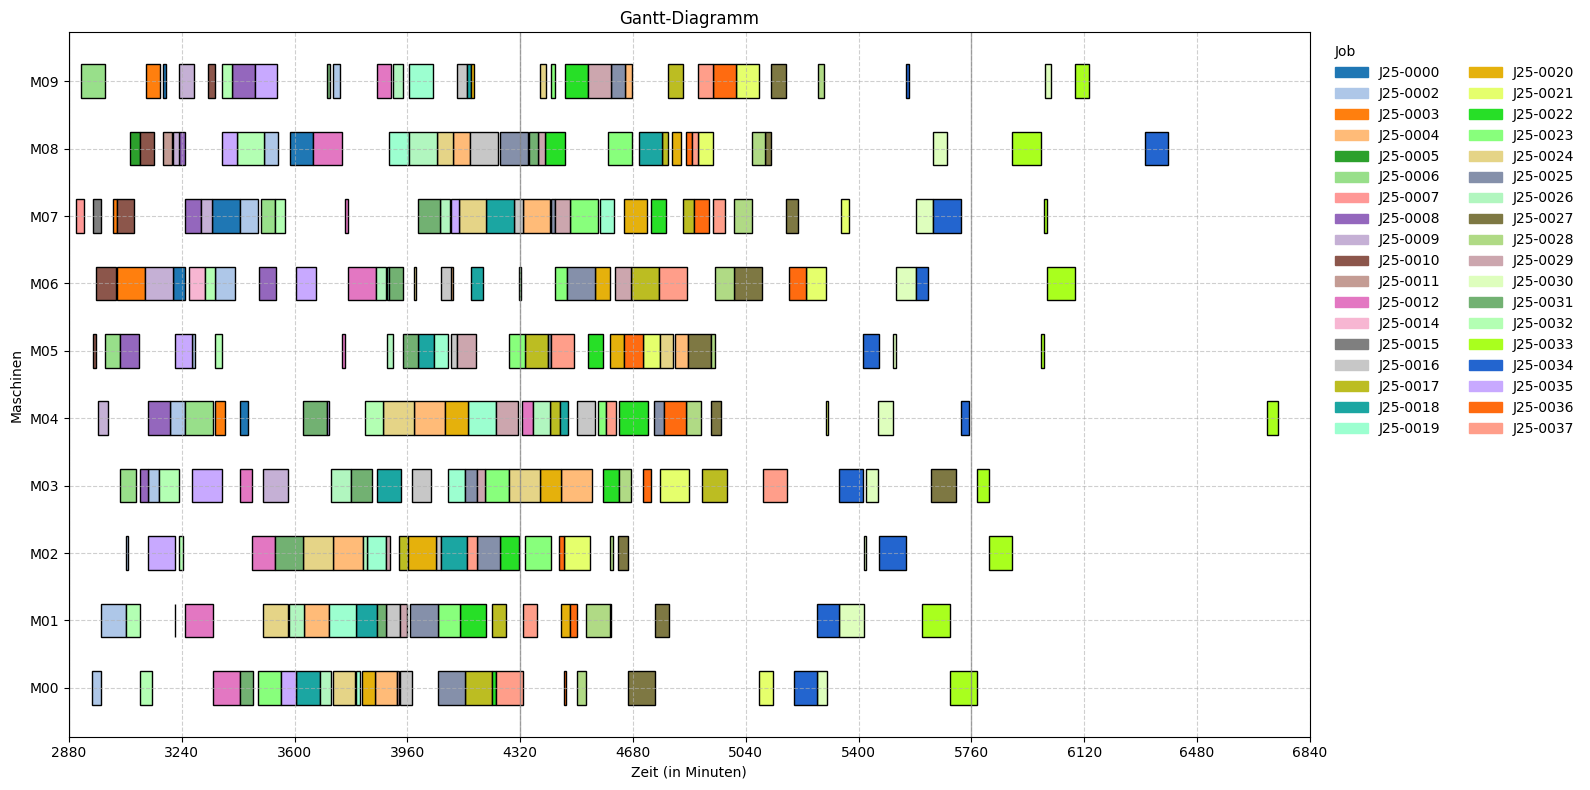

+ No machine conflicts found.
+ All job operations are scheduled in non-overlapping, correct sequence.


True

In [25]:
schedule, experiment_log = solve_jssp_lateness_with_start_deviation_minimization(
    job_ops=job_ops_dict,
    times_dict=times_dict,
    previous_schedule=None,
    active_ops=active_ops,
    w_t=5, w_e=1, w_first=1,
    main_pct=1,
    duration_buffer_factor = 2,
    schedule_start=day_start, msg=False,
    solver_time_limit=max_time, solver_relative_gap_limit=0.05
)

print_experiment_log(experiment_log)

df_schedule = get_schedule_dframe(schedule)
gantt.get_plot(df_schedule, perspective="Machine")
check.check_core_schedule_constraints(df_schedule)


In [26]:
get_comparison_dataframe(df_previous_schedule, df_schedule, comparison_start_time=day_start)

,Original Sequence,Revised Sequence,Levenshtein,Kendall Tau
Machine,,,,
M00,"[J25-0002, J25-0012, J25-0004]","[J25-0002, J25-0012, J25-0004]",0,1.000000
M01,"[J25-0002, J25-0012, J25-0004]","[J25-0002, J25-0012, J25-0004]",0,1.000000
M02,"[J25-0002, J25-0012, J25-0004]","[J25-0002, J25-0012, J25-0004]",0,1.000000
M03,"[J25-0008, J25-0006, J25-0002, J25-0012, J25-0...","[J25-0006, J25-0008, J25-0002, J25-0012, J25-0...",2,0.866667
M04,"[J25-0009, J25-0008, J25-0006, J25-0002, J25-0...","[J25-0009, J25-0008, J25-0002, J25-0006, J25-0...",3,0.857143
M05,"[J25-0010, J25-0008, J25-0006, J25-0002, J25-0...","[J25-0010, J25-0006, J25-0008, J25-0002, J25-0...",2,0.866667
M06,"[J25-0010, J25-0003, J25-0009, J25-0000, J25-0...","[J25-0010, J25-0003, J25-0009, J25-0000, J25-0...",0,1.000000
M07,"[J25-0007, J25-0003, J25-0015, J25-0010, J25-0...","[J25-0007, J25-0015, J25-0003, J25-0010, J25-0...",4,0.890909
M08,"[J25-0005, J25-0010, J25-0008, J25-0011, J25-0...","[J25-0005, J25-0010, J25-0011, J25-0009, J25-0...",2,0.888889


In [27]:
sum_levenshtein = compute_sum_levenshtein_distance(df_previous_schedule, df_schedule, comparison_start_time=day_start)
mean_kendall_tau = compute_mean_kendall_tau(df_previous_schedule, df_schedule, comparison_start_time=day_start)
shared_operations_number = get_shared_operations_number(df_previous_schedule, df_schedule, comparison_start_time=day_start)
print(f"Sum Levenshtein: {sum_levenshtein} (over {shared_operations_number} shared operations)")
print(f"Mean kendall tau: {mean_kendall_tau:.2f}")

Sum Levenshtein: 17 (over 67 shared operations)
Mean kendall tau: 0.91


In [28]:
df_schedule_with_times = enrich_schedule_dframe(df_schedule, df_jobs_times_current, on= "Job")
df_last_ops_with_metrics = get_jobs_with_lateness_metrics(df_schedule_with_times)
get_jobs_aggregated(df_last_ops_with_metrics, column="Tardiness")

Tardiness_Interval,0,0 - 60,60 - 120,>120
count,36,0,0,0


### b) with 'start' deviation penalty


===== EXPERIMENT LOG SUMMARY =====
[EXPERIMENT_INFO]
  total_number_of_operations                        : 287
  number_of_operations_with_previous_schedule       : 67
  number_of_active_operation_to_consider            : 3
  schedule_start                                    : 2880
[EXPERIMENT_CONFIG]
  main_pct                                          : 0.5
  w_t                                               : 5
  w_e                                               : 1
  w_first                                           : 1
  deviation_type                                    : start
  solver_time_limit                                 : 180
  solver_relative_gap_limit                         : 0.05
[MODEL_INFO]
  number_of_variables                               : 929
  number_of_constraints                             : 1193
  number_of_deviation_terms                         : 67
[SOLVER_INFO]
  status                                            : OPTIMAL
  objective_value             

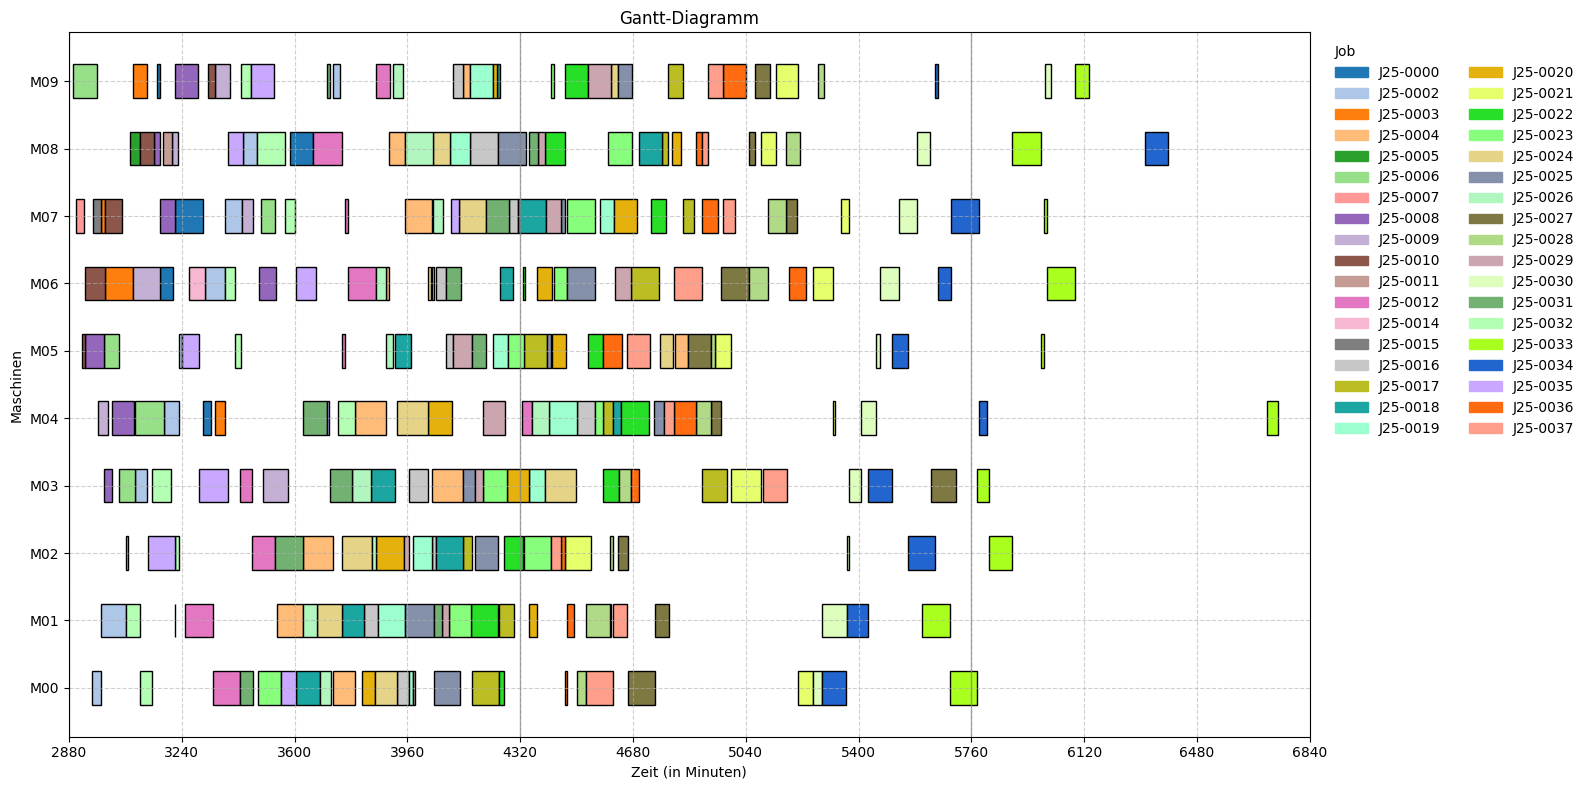

+ No machine conflicts found.
+ All job operations are scheduled in non-overlapping, correct sequence.

Sum Levenshtein: 4 (over 67 shared operations)
Mean kendall tau: 0.99


In [29]:
schedule, experiment_log = solve_jssp_lateness_with_start_deviation_minimization(
    job_ops=job_ops_dict,
    times_dict=times_dict,
    previous_schedule=previous_schedule,
    active_ops=active_ops,
    w_t=5, w_e=1, w_first=1,
    main_pct=(1/2),                  # 50% Lateness, 50% Deviation
    duration_buffer_factor = 2,
    schedule_start=day_start, msg=False,
    solver_time_limit=max_time, solver_relative_gap_limit=0.05
)

print_experiment_log(experiment_log)

df_schedule = get_schedule_dframe(schedule)
gantt.get_plot(df_schedule, perspective="Machine")
check.check_core_schedule_constraints(df_schedule)

sum_levenshtein = compute_sum_levenshtein_distance(df_previous_schedule, df_schedule, comparison_start_time=day_start)
mean_kendall_tau = compute_mean_kendall_tau(df_previous_schedule, df_schedule, comparison_start_time=day_start)
shared_operations_number = get_shared_operations_number(df_previous_schedule, df_schedule, comparison_start_time=day_start)
print(f"\nSum Levenshtein: {sum_levenshtein} (over {shared_operations_number} shared operations)")
print(f"Mean kendall tau: {mean_kendall_tau:.2f}")

In [30]:
df_schedule_with_times = enrich_schedule_dframe(df_schedule, df_jobs_times_current, on= "Job")
df_last_ops_with_metrics = get_jobs_with_lateness_metrics(df_schedule_with_times)
get_jobs_aggregated(df_last_ops_with_metrics, column="Tardiness")

Tardiness_Interval,0,0 - 60,60 - 120,>120
count,36,0,0,0


### c) with 'order on machines' deviation penalty


===== EXPERIMENT LOG SUMMARY =====
[EXPERIMENT_INFO]
  total_number_of_operations                        : 287
  number_of_operations_with_previous_schedule       : 67
  number_of_active_operation_to_consider            : 3
  schedule_start                                    : 2880
[EXPERIMENT_CONFIG]
  main_pct                                          : 0.5
  w_t                                               : 5
  w_e                                               : 1
  w_first                                           : 1
  deviation_type                                    : order_on_machine
  solver_time_limit                                 : 180
  solver_relative_gap_limit                         : 0.05
[MODEL_INFO]
  number_of_variables                               : 1025
  number_of_constraints                             : 1519
  number_of_deviation_terms                         : 230
[SOLVER_INFO]
  status                                            : OPTIMAL
  objective_value

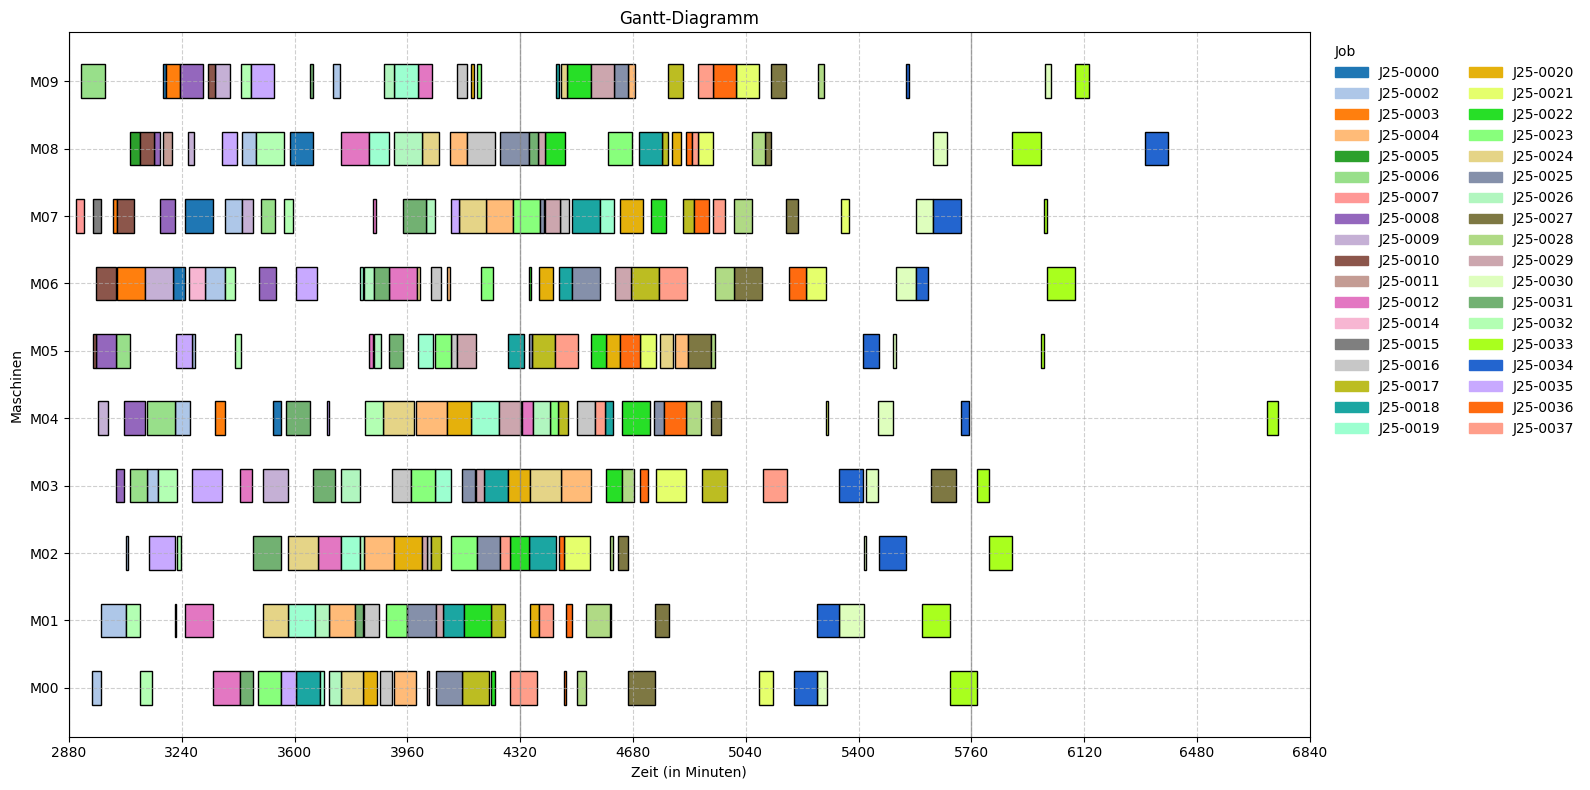

+ No machine conflicts found.
+ All job operations are scheduled in non-overlapping, correct sequence.

Sum Levenshtein: 4 (over 67 shared operations)
Mean kendall tau: 0.99


In [31]:
schedule, experiment_log = solve_jssp_lateness_with_order_deviation_minimization(
    job_ops=job_ops_dict,
    times_dict=times_dict,
    previous_schedule=previous_schedule,
    active_ops=active_ops,
    w_t=5, w_e=1, w_first=1,
    main_pct=(1/2),                  # 50% Lateness, 50% Deviation
    duration_buffer_factor = 2,
    schedule_start=day_start, msg=False,
    solver_time_limit=max_time, solver_relative_gap_limit=0.05
)

print_experiment_log(experiment_log)

df_schedule = get_schedule_dframe(schedule)
gantt.get_plot(df_schedule, perspective="Machine")
check.check_core_schedule_constraints(df_schedule)

sum_levenshtein = compute_sum_levenshtein_distance(df_previous_schedule, df_schedule, comparison_start_time=day_start)
mean_kendall_tau = compute_mean_kendall_tau(df_previous_schedule, df_schedule, comparison_start_time=day_start)
shared_operations_number = get_shared_operations_number(df_previous_schedule, df_schedule, comparison_start_time=day_start)
print(f"\nSum Levenshtein: {sum_levenshtein} (over {shared_operations_number} shared operations)")
print(f"Mean kendall tau: {mean_kendall_tau:.2f}")

In [32]:
df_schedule_with_times = enrich_schedule_dframe(df_schedule, df_jobs_times_current, on= "Job")
df_last_ops_with_metrics = get_jobs_with_lateness_metrics(df_schedule_with_times)
get_jobs_aggregated(df_last_ops_with_metrics, column="Tardiness")

Tardiness_Interval,0,0 - 60,60 - 120,>120
count,36,0,0,0


#### Check the conditions of the combined data set from the simulation data with the new schedule

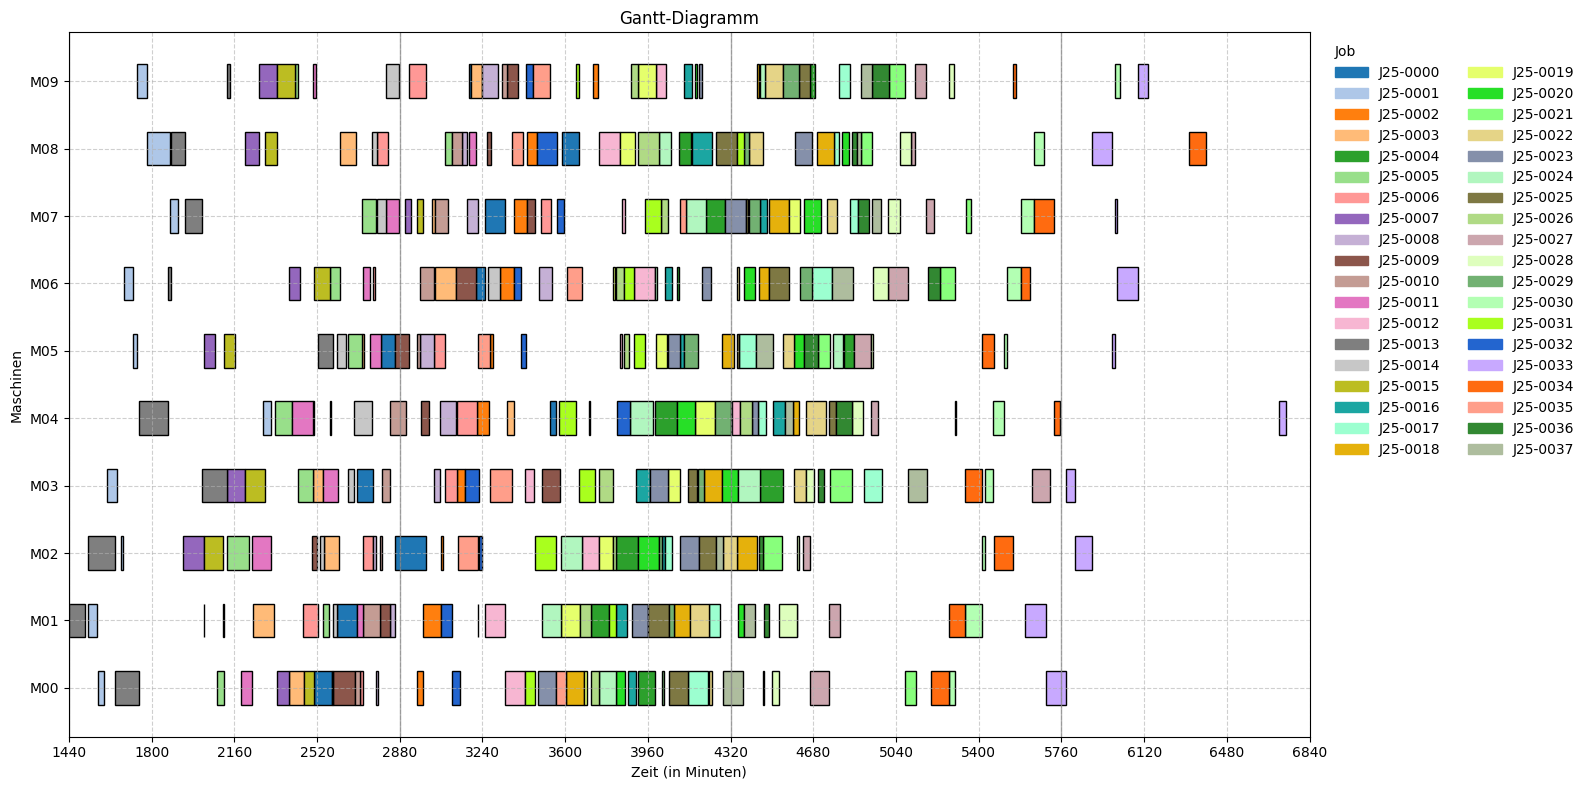

+ No machine conflicts found.
+ All job operations are scheduled in non-overlapping, correct sequence.


True

In [33]:
df_reschedule = df_schedule

columns = ["Job", "Operation", "Machine", "Start", "Processing Time", "End"]
df_combined = pd.concat([df_execution, df_active[columns], df_reschedule[columns]], ignore_index=True)
gantt.get_plot(df_combined, perspective="Machine")
check.check_core_schedule_constraints(df_combined)

### Simulation

In [34]:
simulation.run(dframe_schedule_plan = df_schedule, start_time = day_start, end_time = day_end)

[Day 2 00:00:00] Job J25-0010, Operation 4 resumed on M04 (with 25 minutes left)
[Day 2 00:00:00] Job J25-0009, Operation 3 resumed on M05 (with 41 minutes left)
[Day 2 00:00:00] Job J25-0000, Operation 4 resumed on M02 (with 115 minutes left)
[Day 2 00:24:00] Job J25-0007 started on M07
[Day 2 00:25:00] Job J25-0010 finished on M04 (after 25 minutes)
[Day 2 00:39:00] Job J25-0006 started on M09
[Day 2 00:41:00] Job J25-0009 finished on M05 (after 41 minutes)
[Day 2 00:43:00] Job J25-0007 finished on M07 (after 19 minutes)
[Day 2 01:14:00] Job J25-0002 started on M00
[Day 2 01:16:00] Job J25-0015 started on M07
[Day 2 01:17:00] Job J25-0010 started on M05
[Day 2 01:34:00] Job J25-0009 started on M04
[Day 2 01:35:00] Job J25-0010 finished on M05 (after 18 minutes)
[Day 2 01:35:00] Job J25-0008 started on M05
[Day 2 01:35:00] Job J25-0010 started on M06
[Day 2 01:50:00] Job J25-0015 finished on M07 (after 34 minutes)
[Day 2 01:53:00] Job J25-0002 finished on M00 (after 39 minutes)
[Day 2

In [35]:
df_execution2 = simulation.get_finished_operations_df()
df_execution2

,Job,Operation,Machine,Start,Processing Time,End
0,J25-0000,4,M02,2860.0,135.0,2995.0
1,J25-0000,5,M09,3180.0,9.0,3189.0
2,J25-0000,6,M06,3225.0,35.0,3260.0
3,J25-0000,7,M07,3260.0,91.0,3351.0
4,J25-0000,8,M04,3532.0,31.0,3563.0
5,J25-0000,9,M08,3594.0,85.0,3679.0
...,...,...,...,...,...,...
151,J25-0035,5,M09,3469.0,72.0,3541.0
152,J25-0035,6,M00,3572.0,58.0,3630.0
153,J25-0035,7,M06,3630.0,66.0,3696.0


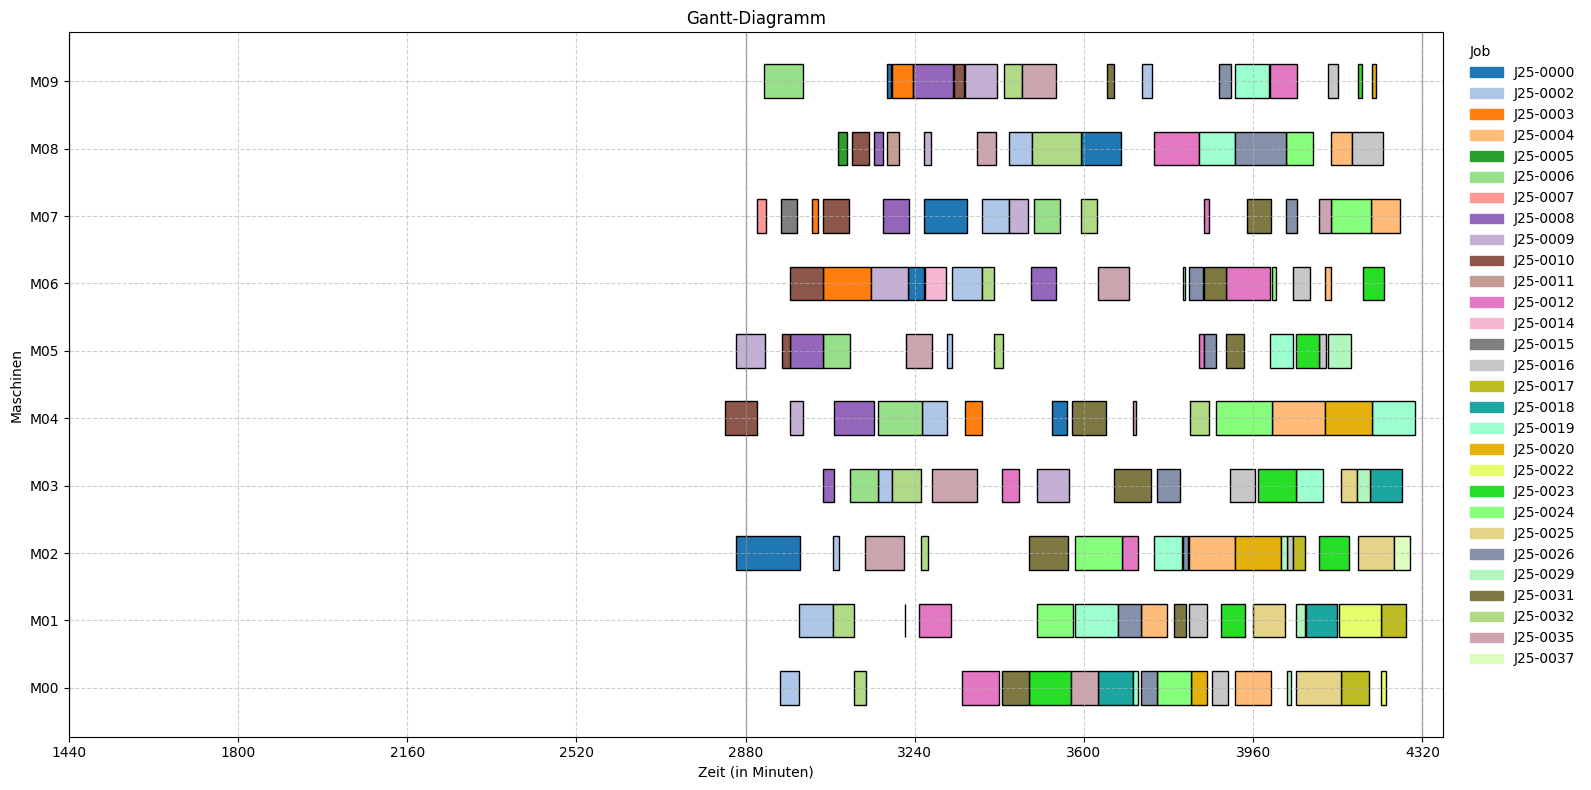

In [36]:
gantt.get_plot(df_execution2, perspective="Machine")

In [37]:
df_active2 = simulation.get_active_operations_df()
df_active2

,Job,Operation,Machine,Start,Processing Time,End,Expected End
0,J25-0018,3,M05,4282.0,49.0,4331.0,4333.0
1,J25-0020,4,M03,4282.0,46.0,4328.0,4351.0
2,J25-0022,2,M02,4293.0,56.0,4349.0,4354.0
3,J25-0023,7,M07,4296.0,93.0,4389.0,4385.0
4,J25-0025,4,M08,4259.0,75.0,4334.0,4349.0
5,J25-0029,5,M04,4305.0,68.0,4373.0,4374.0
6,J25-0037,1,M00,4293.0,130.0,4423.0,4379.0


#### Check the conditions of the combined data set from the two simulation data sets

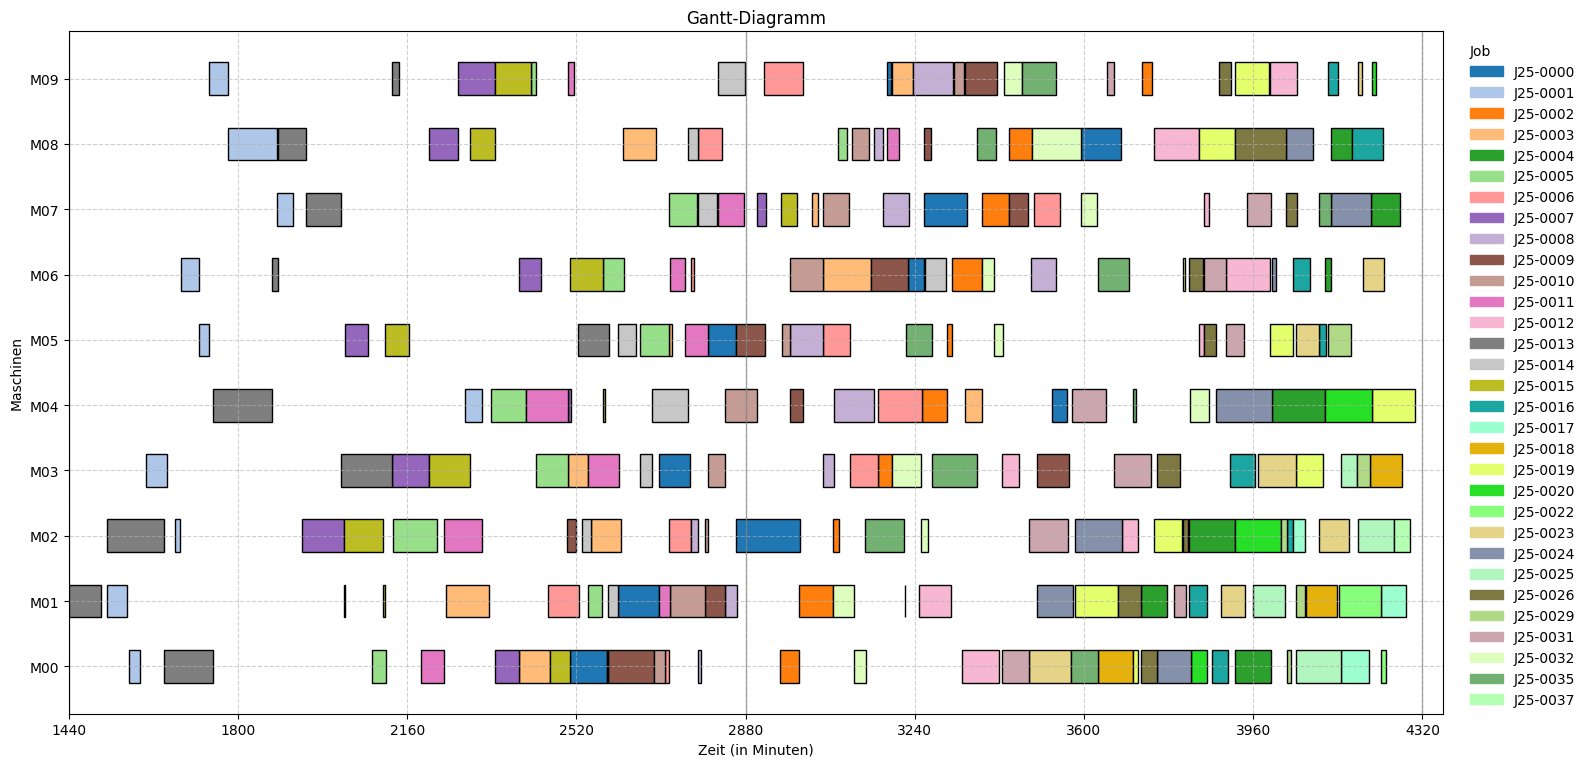

+ No machine conflicts found.
+ All job operations are scheduled in non-overlapping, correct sequence.


True

In [38]:
df_combined = pd.concat([df_execution, df_execution2], ignore_index=True)
gantt.get_plot(df_combined, perspective="Machine")
check.check_core_schedule_constraints(df_combined)